In [1]:
import pickle
# from collections import defaultdict
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
file_path = 'sim_results.pkl'

with open(file_path, 'rb') as f:
    results = pickle.load(f)

In [3]:
attributes = ['STR','DEX','CON','INT','WIS','CHA']

attribute_map = {
    0: 'STR',
    1: 'DEX',
    2: 'CON',
    3: 'INT',
    4: 'WIS',
    5: 'CHA'
}

attribute_scores = {}
# Iterate through the 50 iterations (results) for the 10,000 characters
for i in range(50):
    stat_arrays = results[i][8]
    attribute_scores[i] = []
    for char_id, char_stats in stat_arrays.items():
        attribute_scores[i].append(char_stats)

In [4]:
correlations = {}

for i in tqdm(range(50)):
    data = attribute_scores[i]  
    atts = {j: [] for j in range(6)} 
    
    for d in data:
        for j in range(6):
            atts[j].append(d[j])  
            
    if i not in correlations:
        correlations[i] = {}
    
    for j in range(6):
        for k in range(6):
            correlations[i][j, k] = np.corrcoef(atts[j], atts[k])[0, 1]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 20.75it/s]


In [5]:
# Function to calculate Fisher Z-transformation
def fisher_z(correlation):
    return 0.5 * np.log((1 + correlation) / (1 - correlation))

# Function to inverse Fisher Z-transformation
def inverse_fisher_z(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# Function to calculate 95% confidence intervals for each correlation coefficient
def calculate_ci(correlation_values, alpha=0.05):
    n = len(correlation_values)  # Number of samples (50 in your case)
    
    # Apply Fisher Z-transformation to the correlation values
    z_values = np.array([fisher_z(r) for r in correlation_values])
    
    # Calculate the mean and standard error of the Z values
    z_mean = np.mean(z_values)
    z_se = np.std(z_values, ddof=1) / np.sqrt(n)
    
    # Calculate the confidence interval in the Z space
    z_ci_lower = z_mean - 1.96 * z_se
    z_ci_upper = z_mean + 1.96 * z_se
    
    # Inverse Fisher Z-transformation to get the CI in the correlation space
    r_ci_lower = inverse_fisher_z(z_ci_lower)
    r_ci_upper = inverse_fisher_z(z_ci_upper)
    
    return r_ci_lower, r_ci_upper

# Initialize the dictionary with your 50 correlation matrices (assuming 'correlations' is the dictionary with your 50 matrices)
confidence_intervals = np.zeros((6, 6, 2))  # 6x6 matrix with 2 columns (lower and upper bounds)

# Iterate over each pair of attributes (j, k)
for j in range(6):  # Loop through the rows (attributes)
    for k in range(6):  # Loop through the columns (attributes)
        # Collect the correlation values for this pair across all 50 datasets
        correlation_values = [correlations[i].get((j, k), np.nan) for i in range(50)]
        
        # Remove NaN values (in case there were any missing correlations)
        correlation_values = [r for r in correlation_values if not np.isnan(r)]
        
        # Calculate the CI for this pair of attributes
        ci_lower, ci_upper = calculate_ci(correlation_values)
        
        # Store the CI in the matrix (lower and upper bounds)
        confidence_intervals[j, k, 0] = ci_lower  # Lower bound
        confidence_intervals[j, k, 1] = ci_upper

/home/simonhans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simonhans/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


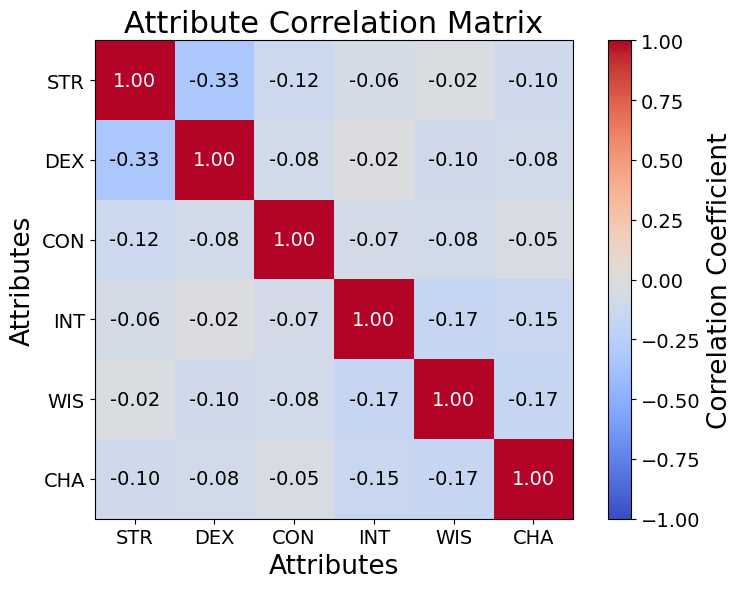

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the attribute labels
attribute_labels = ['STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']

# Assuming confidence_intervals is your 6x6 array containing the CI lower and upper bounds
# You will take the average of the lower and upper bounds to represent the final correlation value

# Calculate the average correlation value for each pair (j, k)
average_correlation_matrix = np.zeros((6, 6))

for j in range(6):
    for k in range(6):
        lower_bound = confidence_intervals[j, k, 0]
        upper_bound = confidence_intervals[j, k, 1]
        
        average_correlation_matrix[j, k] = (lower_bound + upper_bound) / 2
np.fill_diagonal(average_correlation_matrix, 1)


fig, ax = plt.subplots(figsize = (8,6))
# plt.figure(figsize=(8, 6))
cax = plt.imshow(
    average_correlation_matrix,
    cmap='coolwarm',
    interpolation='nearest',
    vmin = -1, vmax = 1
)
cbar = fig.colorbar(cax)

cbar.ax.tick_params(labelsize = 14) 
cbar.set_label('Correlation Coefficient',fontsize = 19)
# Add colorbar to the side
# plt.colorbar(cax, label='Correlation Coefficient')


# Set ticks and labels
plt.xticks(np.arange(6), attribute_labels, fontsize = 14)
plt.yticks(np.arange(6), attribute_labels, fontsize = 14)

# Add labels and title
plt.title('Attribute Correlation Matrix', fontsize = 22)
plt.xlabel('Attributes', fontsize = 19)
plt.ylabel('Attributes', fontsize = 19)

for i in range(6):
    for j in range(6):
        plt.text(j, i,
                 f'{average_correlation_matrix[i, j]:.2f}',
                 ha = 'center', va = 'center', 
                 color = 'black' if average_correlation_matrix[i, j] < 0.5 else 'white',
                 fontsize = '14'
                )

# Show the plot
plt.tight_layout()
plt.savefig('attribute_correlation.png')
plt.show()


In [7]:
average_correlation_matrix

array([[ 1.        , -0.32540269, -0.12127288, -0.06259296, -0.02479665,
        -0.10385026],
       [-0.32540269,  1.        , -0.07971916, -0.01767088, -0.09787131,
        -0.08204279],
       [-0.12127288, -0.07971916,  1.        , -0.07357654, -0.08390724,
        -0.05322432],
       [-0.06259296, -0.01767088, -0.07357654,  1.        , -0.16598558,
        -0.14645215],
       [-0.02479665, -0.09787131, -0.08390724, -0.16598558,  1.        ,
        -0.17185057],
       [-0.10385026, -0.08204279, -0.05322432, -0.14645215, -0.17185057,
         1.        ]])